In [843]:
import pandas as pd

df = pd.read_csv('penguins.csv')
df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [844]:
df.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.755814
std,5.459584,1.974793,14.061714,801.954536,0.762626
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


In [845]:
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)

     CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
3             NaN          NaN            NaN       NaN        0
271           NaN          NaN            NaN       NaN        1


In [846]:
df.dropna(inplace=True)
df.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.757310
std,5.459584,1.974793,14.061714,801.954536,0.763648
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


In [847]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        342 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.0 KB


In [848]:
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'
X, y = df[features], df[target]

In [849]:
pd.Series(y).value_counts(normalize=True)

Species
0    0.441520
1    0.359649
2    0.198830
Name: proportion, dtype: float64

Gatunki 0 i 1 są dosyć zbliżone ilościowo, jednak znacznie mniej jest danych nt. gatunku 2.

Unique values: 164


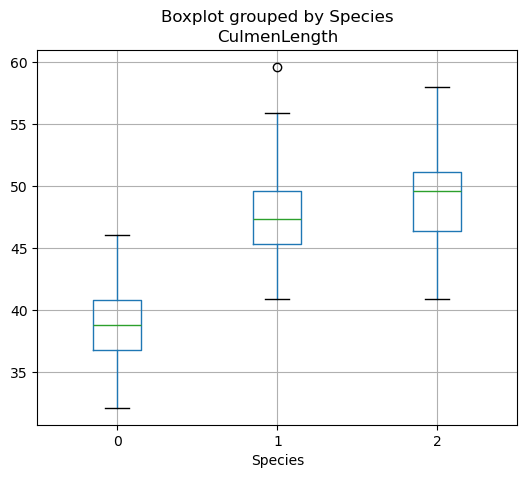

Unique values: 80


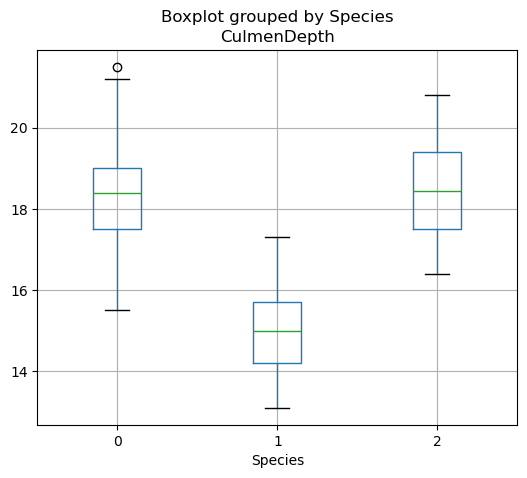

Unique values: 55


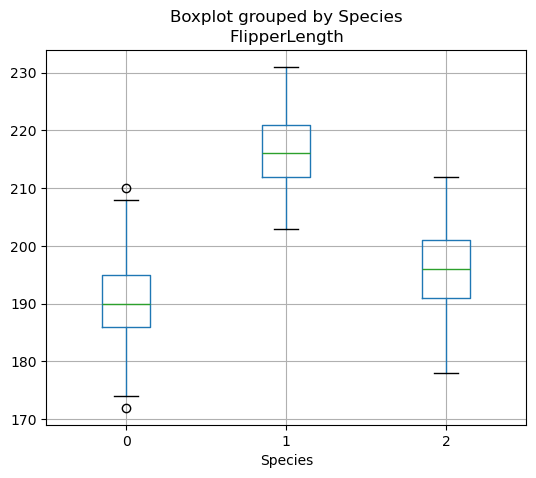

Unique values: 94


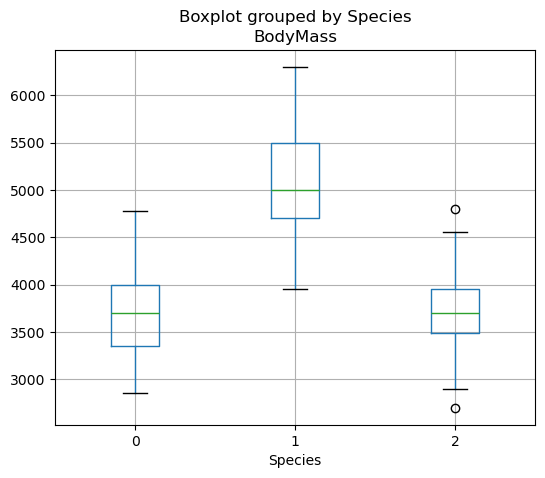

In [850]:
import matplotlib.pyplot as plt
for col in features:
    print(f'Unique values: {len(df[col].unique())}')
    df.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

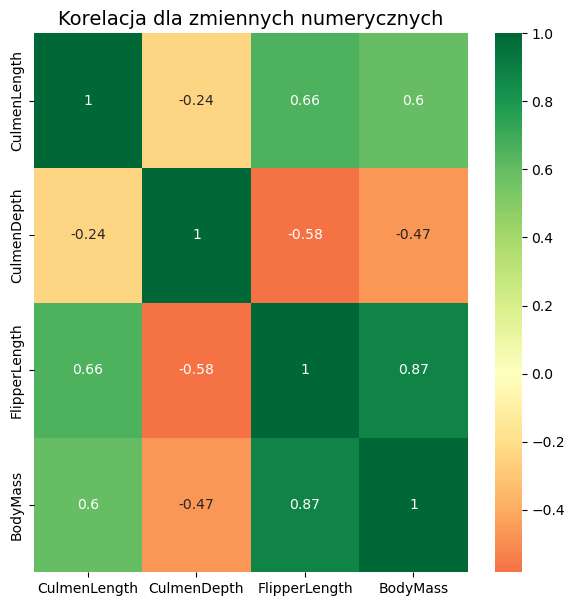

In [851]:
import seaborn as sns

plt.figure(figsize=(7, 7))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Korelacja dla zmiennych numerycznych', fontsize=14)
bottom, top = ax.get_ylim()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Z matrycy korelacji wychodzi, że zmienne np. długość płetwy i masa ciała są ze sobą mocno skorelowane, jednak biorąc pod uwagę jak odmienne są to w rzeczywistości cechy postanowiono zostawić do dalszej analizy wszystkie cechy, tym bardziej, że jest ich mało.

In [852]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

Przynależność do danego gatunku najbardziej zależna jest od długości dzioba, co widać na boxplotach, na tej podstawie teoretycznie można by rozdzielić wszystkie 3 gatunki, natomiast inne cechy również dają jasne różnice, ale w przypadku np. jednego gatunku, a nie wszystkich trzech. Warto wzią wszystki pod uwagę.

In [853]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))

Treningowe obserwacje: 273
Testowe obserwacje: 69


In [854]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

In [855]:
models = []
evaluations = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1-score-test', 'f1_score', 'auc_metric'])

In [856]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


def evaluate_model(model, name, standardized):
    X_to_evaluate = X_test
    X_test_to_evaluate = X_train
    if(standardized):
        X_to_evaluate = X_test_standardized
        X_test_to_evaluate = X_train_standardized
    X_test_to_evaluate
    predictions = model.predict(X_to_evaluate)
    predictions_proba = model.predict_proba(X_to_evaluate)
    y_train_pred = model.predict(X_test_to_evaluate)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1_metric = f1_score(y_test, predictions, average='weighted')
    f1_metric_test = f1_score(y_train, y_train_pred, average='weighted')
    auc_metric = roc_auc_score(y_test, predictions_proba, multi_class='ovr', average='weighted')
    evaluations.loc[len(evaluations)] = {'model_name': name, 'accuracy' : accuracy, 'precision': precision, 'recall': recall, 'f1-score-test': f1_metric_test, 'f1_score' : f1_metric, 'auc_metric' : auc_metric}

In [857]:
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)
models.append({'model' : model_lr, 'name' :'Logistic Regression', 'standardized' : True})

In [858]:
from sklearn.neighbors import KNeighborsClassifier
import math

model_knn = KNeighborsClassifier(n_neighbors= 5)
model_knn.fit(X_train_standardized, y_train)
models.append({'model' : model_knn, 'name' :'KNeighborsClassifier', 'standardized' : True})

In [859]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
model_tree.fit(X_train, y_train)
models.append({'model' : model_tree, 'name' :'DecisionTreeClassifier', 'standardized' : False})

In [860]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf', probability=True)
model_svm.fit(X_train_standardized, y_train)
models.append({'model' : model_svm, 'name' :'SVM', 'standardized' : True})

In [861]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=int(math.sqrt(X_train_standardized.shape[0])))
model_forest.fit(X_train, y_train)
models.append({'model' : model_forest, 'name' :'RandomForestClassifier', 'standardized' : False})

In [862]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=40)
model_adaboost.fit(X_train, y_train)
models.append({'model' : model_adaboost, 'name' :'AdaBoostClassifier', 'standardized' : False})

In [863]:
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')

model_voting.fit(X_train, y_train)
models.append({'model' : model_voting, 'name' :'VotingClassifier', 'standardized' : False})

In [864]:
for m in models:
    evaluate_model(m['model'], m['name'], m['standardized'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
print(evaluations)

               model_name  accuracy  precision    recall  f1-score-test  \
0     Logistic Regression  0.956522   0.956342  0.956522       0.992635   
1    KNeighborsClassifier  0.971014   0.971014  0.971014       0.996327   
2  DecisionTreeClassifier  0.942029   0.942331  0.942029       0.970900   
3                     SVM  0.971014   0.971014  0.971014       0.988921   
4  RandomForestClassifier  0.956522   0.956342  0.956522       0.962798   
5      AdaBoostClassifier  0.956522   0.956342  0.956522       0.992676   
6        VotingClassifier  0.942029   0.942331  0.942029       0.974467   

   f1_score  auc_metric  
0  0.956073    0.998730  
1  0.971014    0.999047  
2  0.940734    0.976183  
3  0.971014    0.998095  
4  0.956073    0.992007  
5  0.956073    0.994230  
6  0.940734    0.993912  


Najlepiej z klasyfikacją poradziły sobie modele SVM oraz KNeighborsClassifier.

In [865]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())

    plt.title(title)
    plt.xlabel('Przewidziane')
    plt.ylabel('Prawdziwe')

    plt.show()

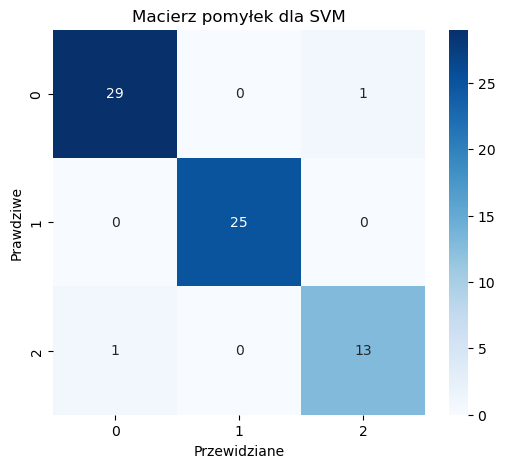

In [866]:
cm = confusion_matrix(y_test, model_svm.predict(X_test_standardized))
print_confusion_matrix(cm, 'Macierz pomyłek dla SVM')

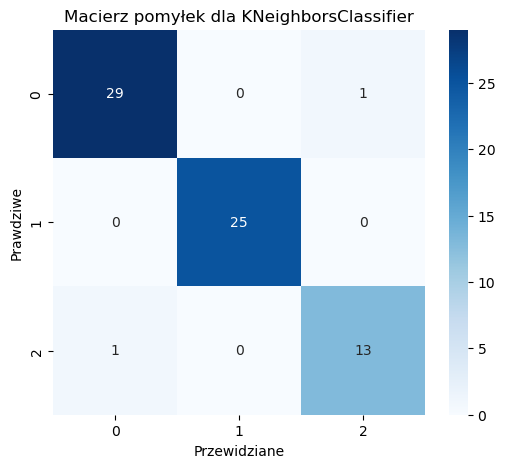

In [867]:
cm = confusion_matrix(y_test, model_knn.predict(X_test_standardized))
print_confusion_matrix(cm, 'Macierz pomyłek dla KNeighborsClassifier')

Oba modele pomyliły się w dwóch przypadkach, co jest dobrym wynikiem, jednak należy pamiętać, że pula danych również nie była duża.